# Prophet

### Benefits of using Prophet:
- Fully automatic: very quick to get forecasts
- Can handle non-linear trend, missing data, outliers, changing trends and holiday effects
- Fast and tunable

### When to use Prophet
- Works best when a lot of data is available
- Very good when time series have strong seasonal effects

## 0. Imports

### 0.1. Libraries

In [ ]:
# Data Manipulation
import pandas               as pd
import numpy                as np

# Data Visualisation
import seaborn              as sns
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates

# Prophet
import pystan

from prophet                import Prophet
from prophet.plot           import add_changepoints_to_plot
from prophet.plot           import plot_yearly
from prophet.plot           import plot_cross_validation_metric
from prophet.diagnostics    import cross_validation, performance_metrics

# Other 
import warnings
import logging

from itertools              import product

### 0.2. Settings

In [3]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')  # Other options: 'default', 'seaborn', 'bmh', 'dark_background'

# Customize rcParams
mpl.rcParams.update({
    'figure.titlesize': 24,
    'figure.figsize': (18, 6),
    'figure.dpi': 150,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 12,
    'xtick.bottom': False,
    'ytick.labelsize': 12,
    'ytick.left': False,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

# Set a color palette
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette)) 

# Logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

### 0.3. Functions

### 0.4. Dataset

In [4]:
df = pd.read_csv('../data/raw/daily-min-temperatures.csv')

## 1. Data Exploration

In [5]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


,Date,Temp
0,1981-01-01,20.70
1,1981-01-02,17.90
2,1981-01-03,18.80
3,1981-01-04,14.60
4,1981-01-05,15.80
...,...,...
3645,1990-12-27,14.00
3646,1990-12-28,13.60
3647,1990-12-29,13.50
3648,1990-12-30,15.70


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,3650.00,11.18,4.07,0.00,8.30,11.00,14.00,26.30


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


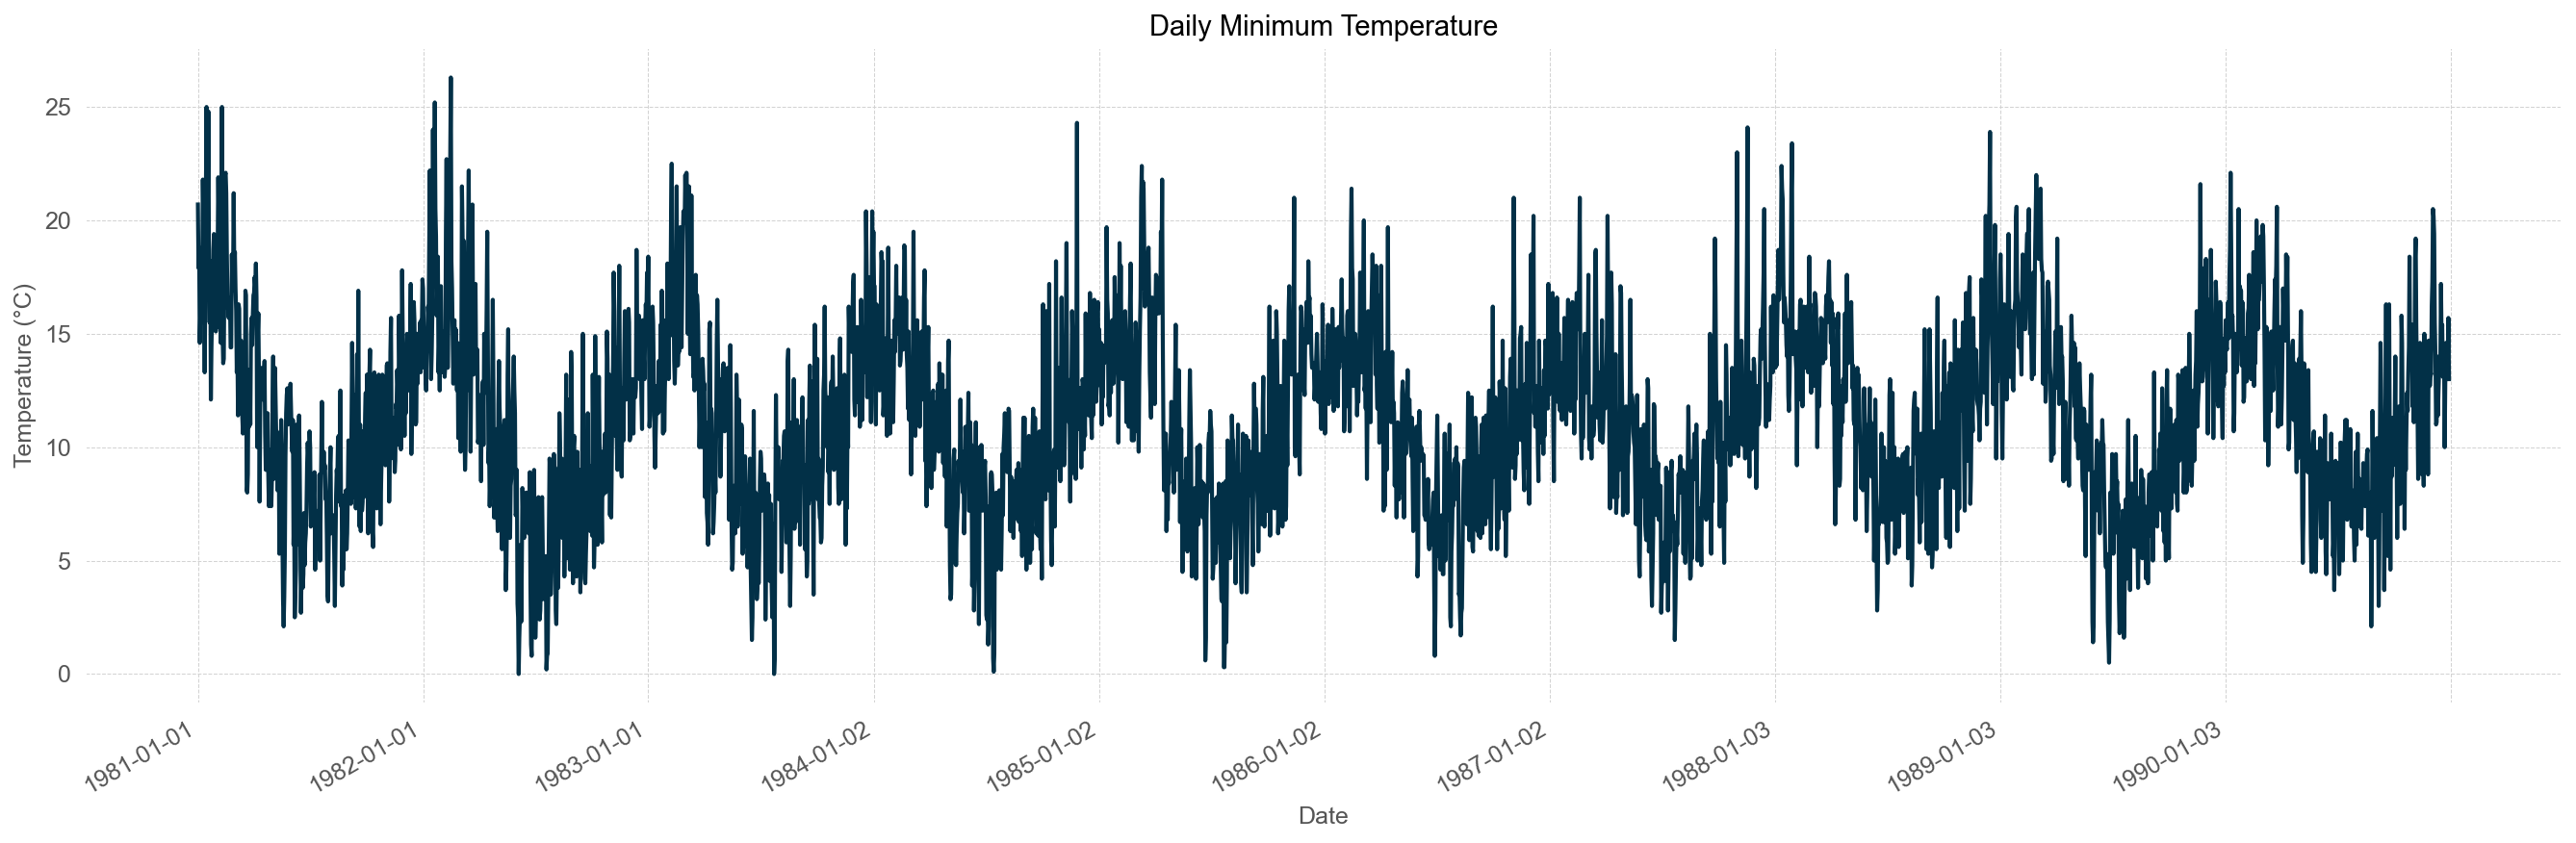

In [7]:
fig, ax = plt.subplots()

locator = mdates.AutoDateLocator()

ax.plot(df.Date, df.Temp)

ax.xaxis.set_major_locator(locator)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Daily Minimum Temperature')

fig.autofmt_xdate() # Automatically format the x-axis date

plt.tight_layout()

plt.show()

## Prophet quickstart

In [8]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1981-01-01,20.70
1,1981-01-02,17.90
2,1981-01-03,18.80
3,1981-01-04,14.60
4,1981-01-05,15.80


In [ ]:
m = Prophet()
m.fit(df);

In [10]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4010,1991-12-27
4011,1991-12-28
4012,1991-12-29
4013,1991-12-30
4014,1991-12-31


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4010,1991-12-27,11.57,10.99,17.83,11.49,11.65,2.90,2.90,2.90,-0.02,-0.02,-0.02,2.92,2.92,2.92,0.00,0.00,0.00,14.47
4011,1991-12-28,11.57,10.82,17.83,11.49,11.65,2.92,2.92,2.92,-0.06,-0.06,-0.06,2.98,2.98,2.98,0.00,0.00,0.00,14.49
4012,1991-12-29,11.57,11.30,18.03,11.49,11.65,2.89,2.89,2.89,-0.15,-0.15,-0.15,3.04,3.04,3.04,0.00,0.00,0.00,14.46
4013,1991-12-30,11.57,11.22,17.98,11.48,11.65,3.09,3.09,3.09,-0.02,-0.02,-0.02,3.11,3.11,3.11,0.00,0.00,0.00,14.66
4014,1991-12-31,11.57,11.47,18.53,11.48,11.65,3.26,3.26,3.26,0.08,0.08,0.08,3.18,3.18,3.18,0.00,0.00,0.00,14.83


In [12]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4010,1991-12-27,14.47,10.99,17.83
4011,1991-12-28,14.49,10.82,17.83
4012,1991-12-29,14.46,11.30,18.03
4013,1991-12-30,14.66,11.22,17.98
4014,1991-12-31,14.83,11.47,18.53


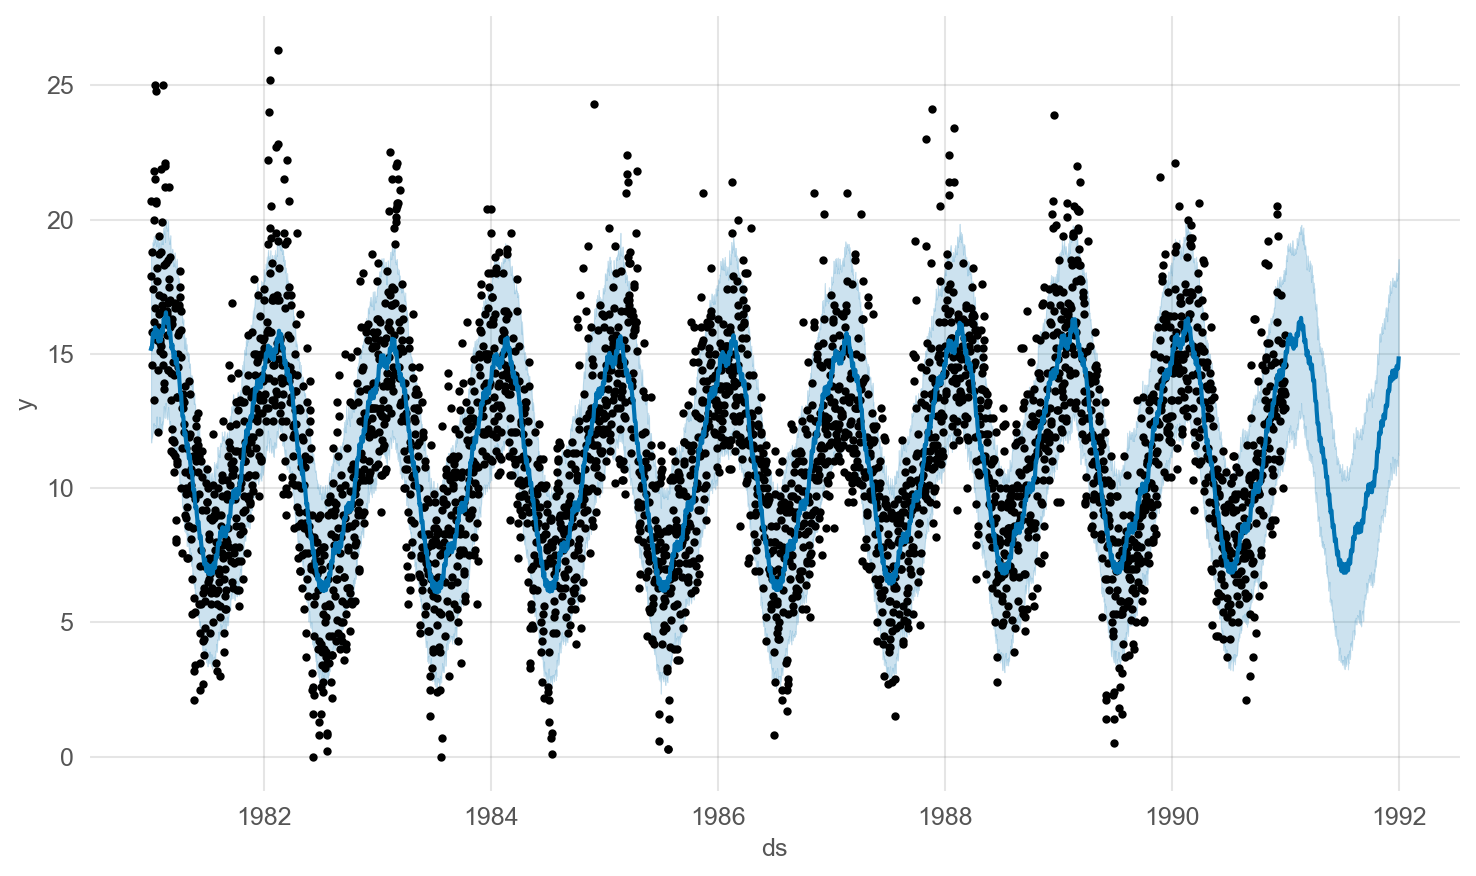

In [13]:
fig1 = m.plot(forecast)

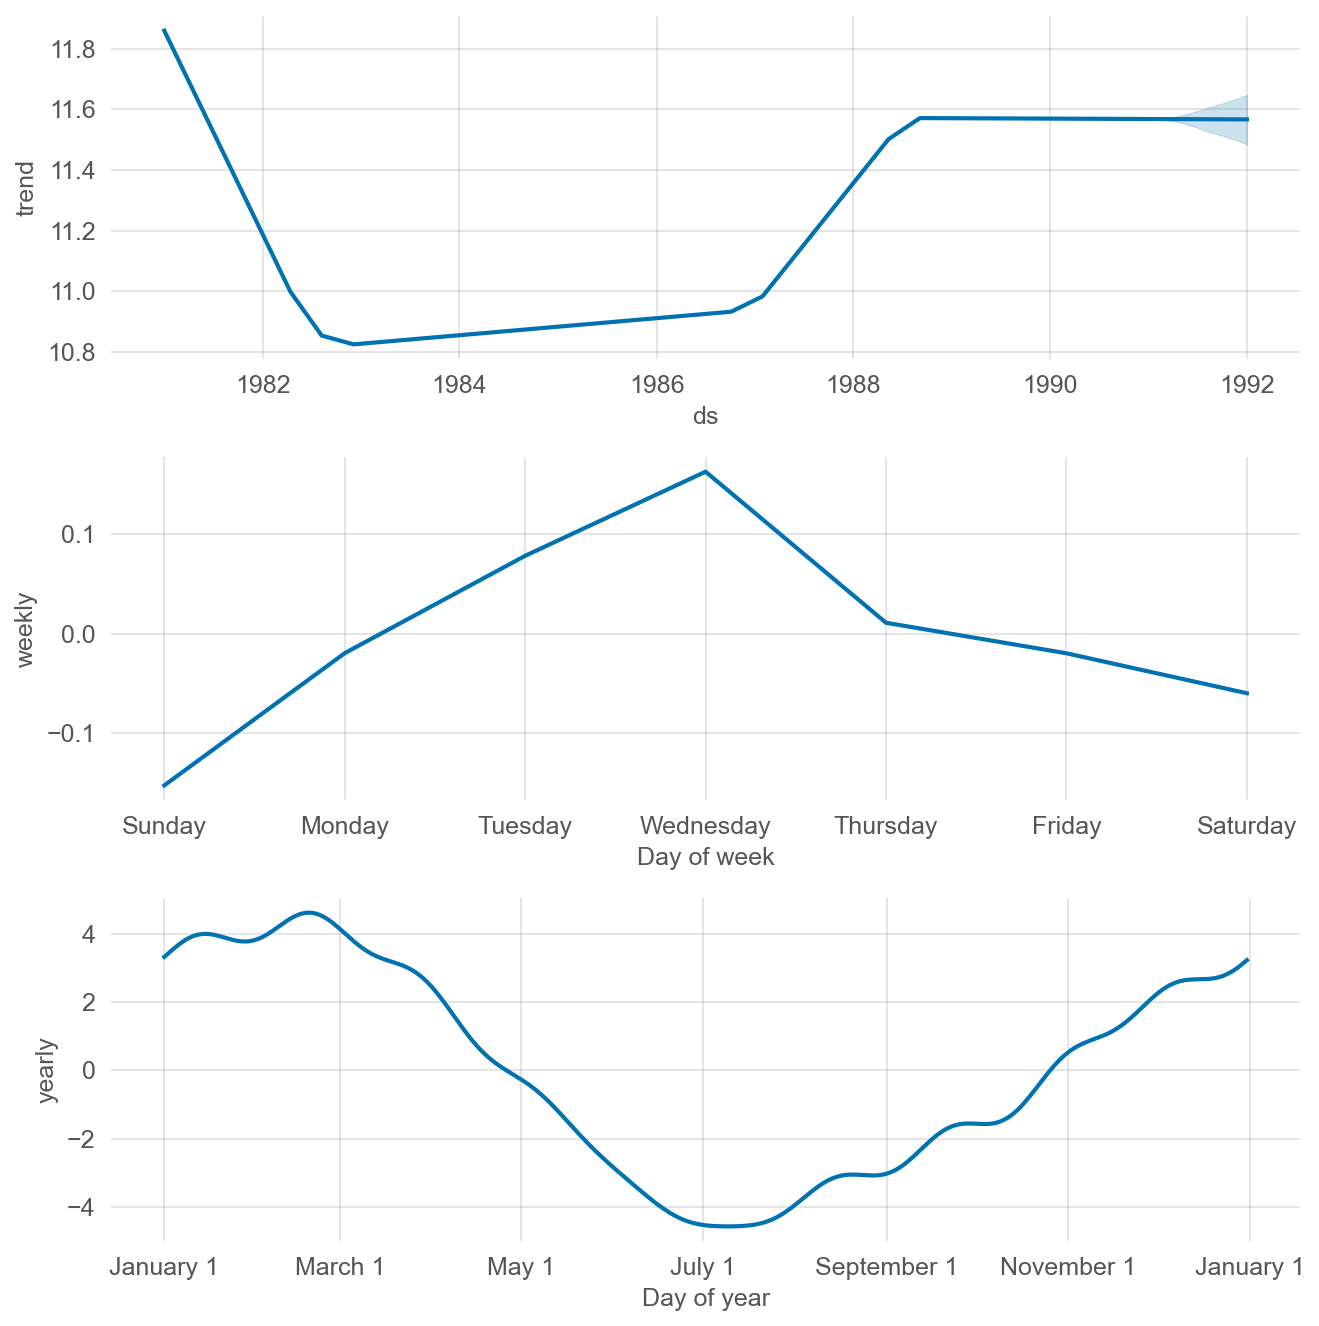

In [14]:
fig2 = m.plot_components(forecast)

## Finding Trend Changepoints
- Prophet can automatically detect points in time where the trend changes
- Prophet will determine a large number of *potential* changepoints at which the trend may change
- Then, Prophet will select as few changepoints as possible to avoid overfitting noisy fluctuations
- The number of changepoints can be tuned with the parameter `n_changepoints`
- By default, Prophet will consider the first 80% of the time series to identify trend changepoints, which can be tuned with `changepoint_range=0.9`


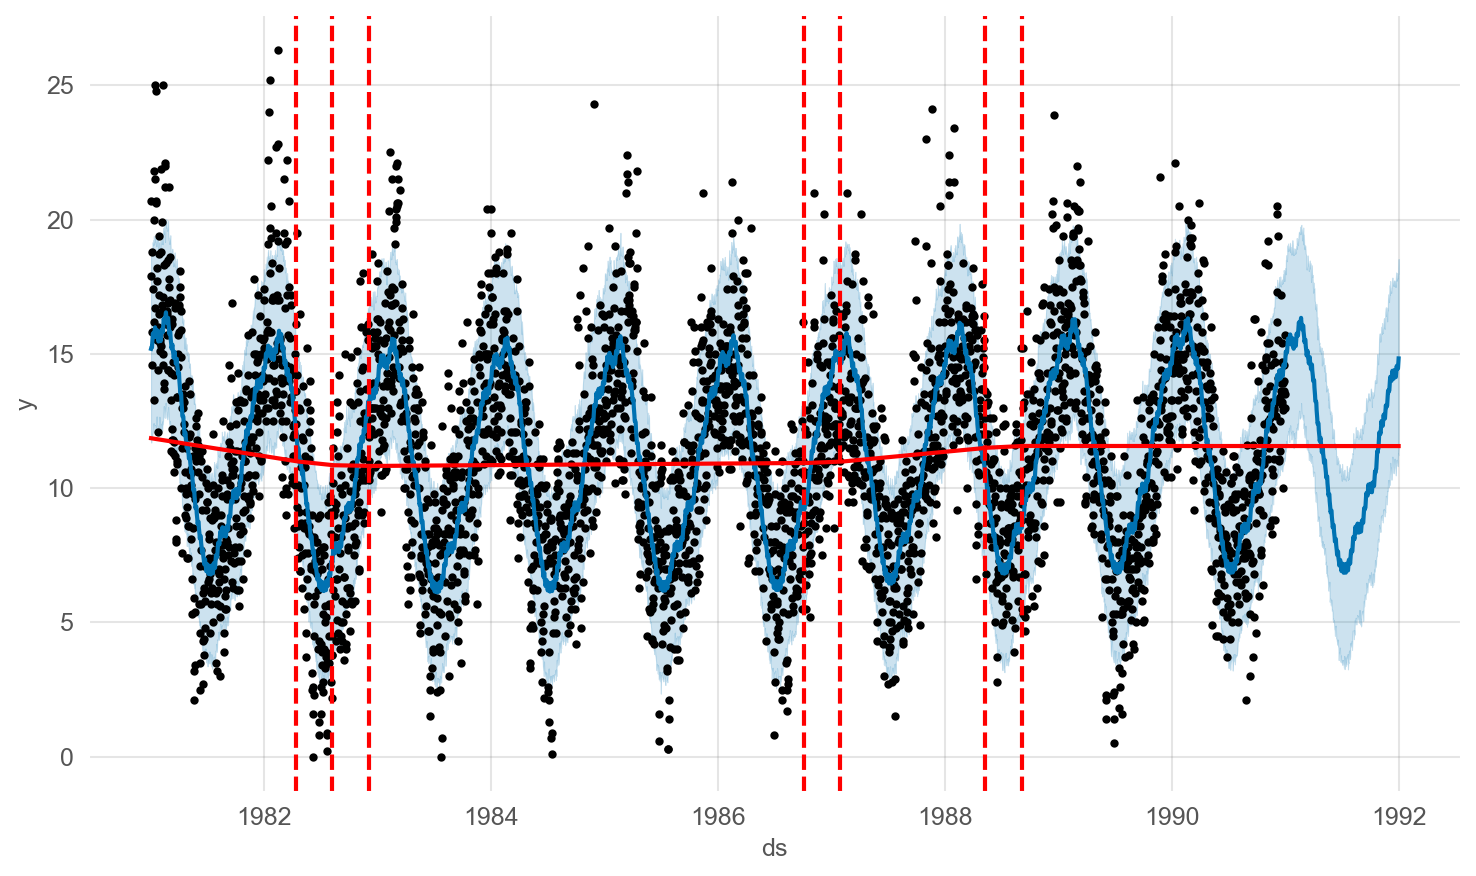

In [15]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Trend Flexibility
- If Prophet is overfitting or underfitting, we can change the *flexibility* of the trend
- This can be tuned with the parameter `changepoint_prior_scale`, which `default=0.5`
    - Increasing the value will make the model **more** flexible (more **variance**)
    - Decreasing the value will make the model **less** flexible (more **bias**)

In [ ]:
m = Prophet(changepoint_prior_scale=0.005).fit(df)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

fig = m.plot(forecast)

## Seasonality
- Depending on the dataset, Prophet can automatically detect the daily, weekly, monthly seasonalities
- Seasonalities are estimated using a partial Fourier sum
- We can specify the order of the partial sum to account for higher-frequency changes, like:
    - Yearly seasonality uses a partial Fourier sum with 10 terms
    - Can specify more terms with `yearly_seasonality=20` to detect smaller changes
    - May lead to overfitting

### Visualize seasonality

In [ ]:
m = Prophet().fit(df)

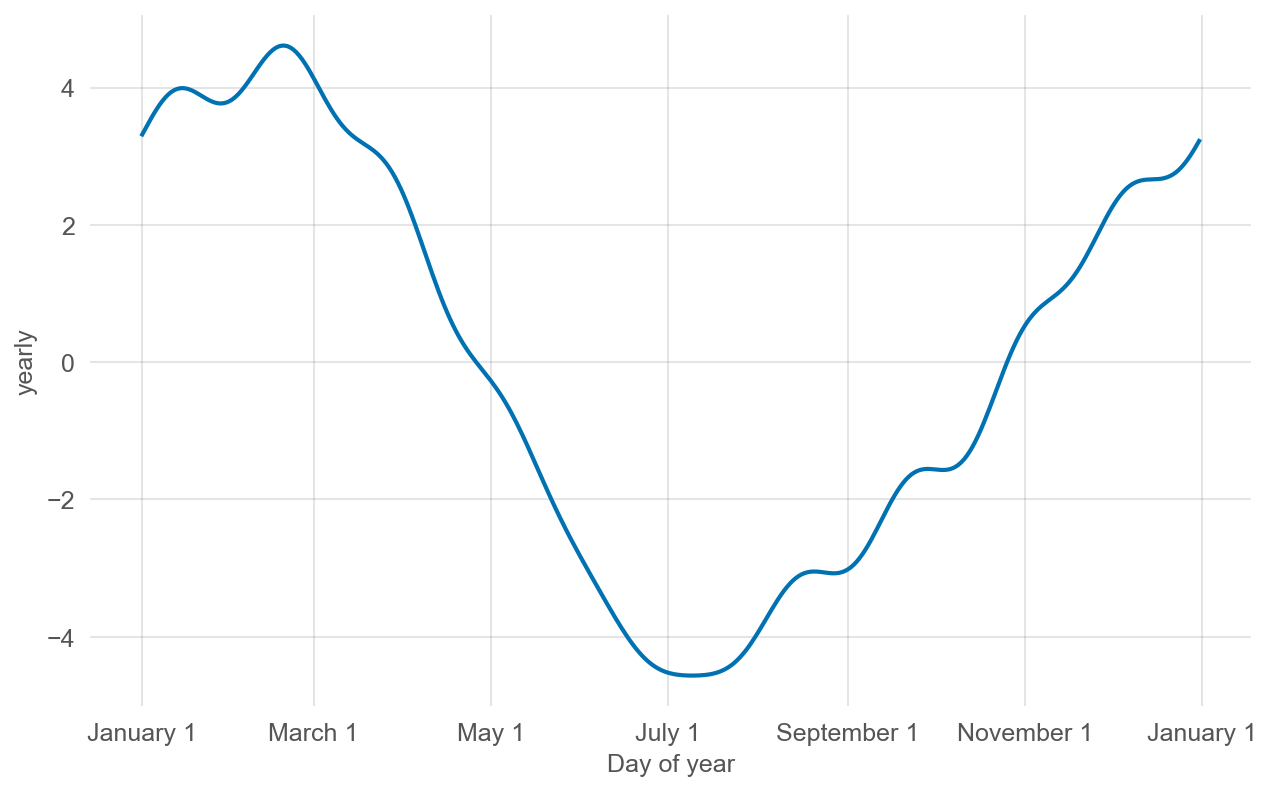

In [42]:
a = plot_yearly(m)

In [ ]:
# Increasing the number of parameters in the Fourier sum to pick up more fluctuations
# May lead to overfitting
m = Prophet(yearly_seasonality=20).fit(df)

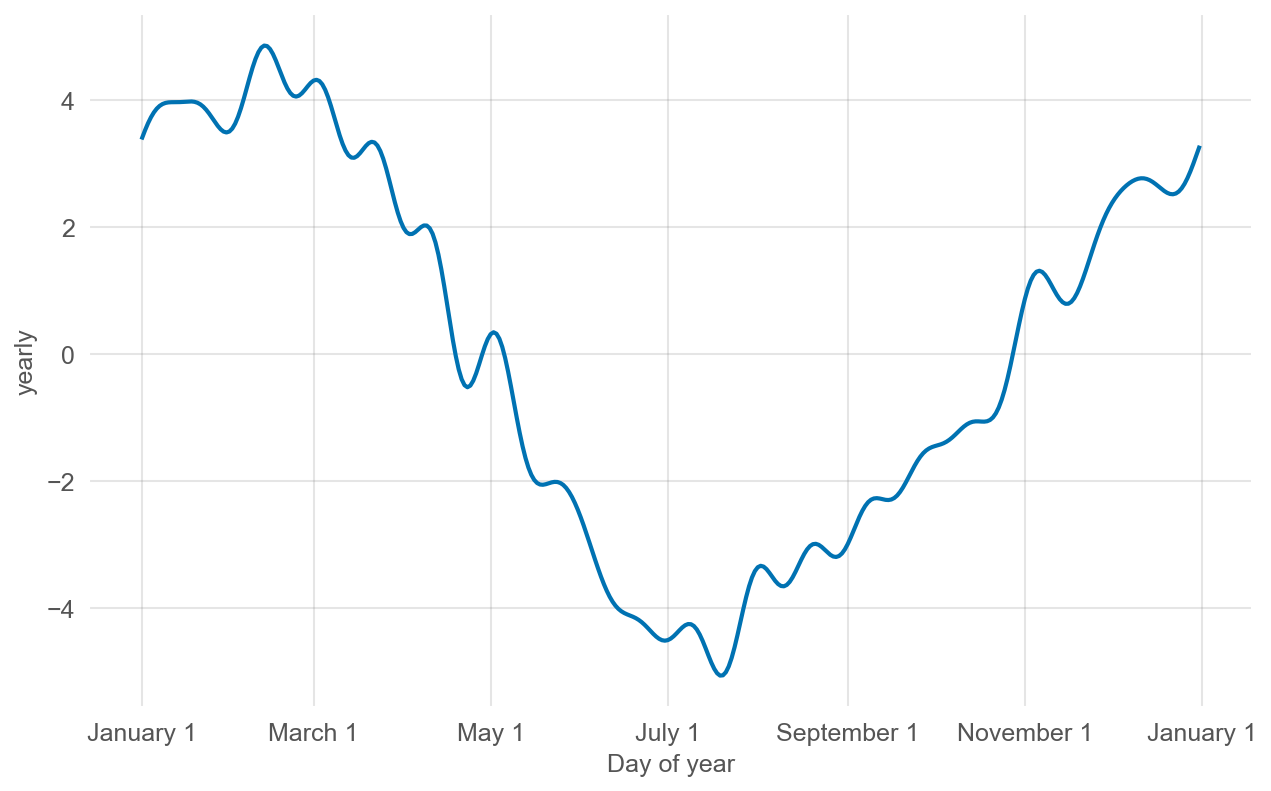

In [44]:
a = plot_yearly(m)

## Uncertainty Intervals
- By default, Prophet dipplays ans 80% uncertainty interval
- It can be configured with the parameter `interval_width=0.95`

In [ ]:
m = Prophet(interval_width=0.95).fit(df)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

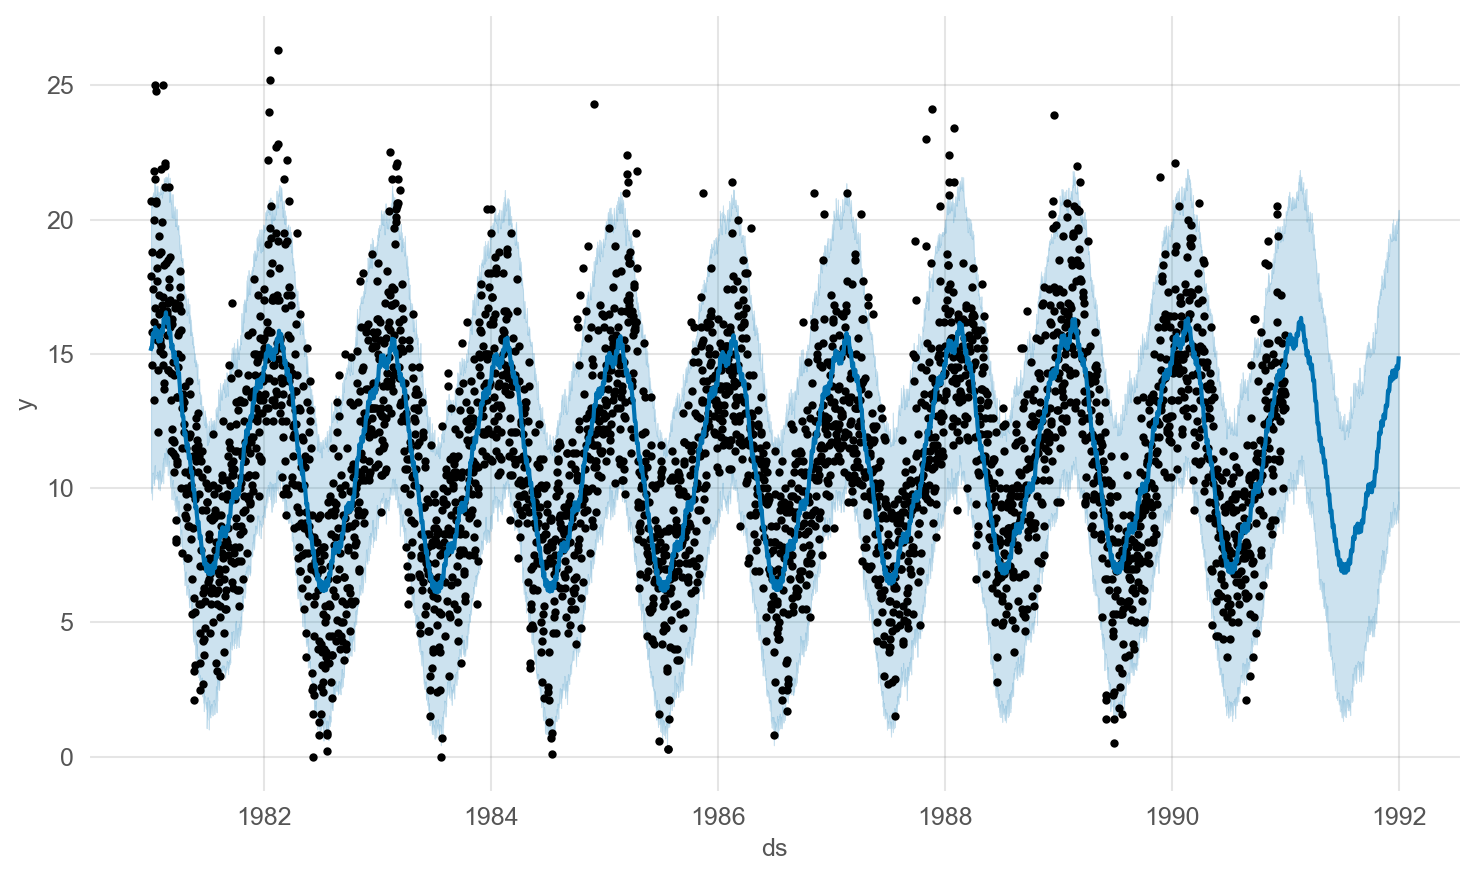

In [46]:
fig = m.plot(forecast)

## Cross-validation and performance metrics
- Cross-validation is really important as it helps us evaluate our model and perform hyper-parameter tuning to obtain the best model possible
- Parameters for cross-validation function are:
    - `horizon`: how many periods into the future to forecast, in days (length of periods)
    - `initial`: how many periods of training data to use before making predictions, in days (length of periods)
    - `period`: how many days to move forward in each iteration of cross-validation, in days (spacing between cutoff periods)
- Rule of thumb:
    - `horizon` should be set first;
    - `initial` should be 3x of the `horizon`
    - `period` should be 1/2 of the `horizon`

In [ ]:
# The parameter only take lengths as days or shorter periods
df_cv = cross_validation(m, initial='730 days', horizon='365 days', period='180 days') 
# Predicting one year at a time

In [32]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-02-07,15.49,11.97,19.30,20.30,1983-02-06
1,1983-02-08,15.52,11.88,19.14,22.50,1983-02-06
2,1983-02-09,15.49,11.90,19.13,17.20,1983-02-06
3,1983-02-10,15.09,11.49,18.49,15.90,1983-02-06
4,1983-02-11,15.47,11.59,19.12,16.80,1983-02-06


In [34]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,37 days,7.79,2.79,2.17,0.15,0.22,0.81
1,38 days,7.63,2.76,2.15,0.15,0.21,0.81
2,39 days,7.41,2.72,2.12,0.15,0.21,0.82
3,40 days,7.35,2.71,2.11,0.15,0.21,0.82
4,41 days,7.39,2.72,2.12,0.16,0.21,0.82
...,...,...,...,...,...,...,...
324,361 days,7.24,2.69,2.13,0.17,0.25,0.84
325,362 days,7.36,2.71,2.14,0.18,0.25,0.83
326,363 days,7.37,2.72,2.14,0.17,0.25,0.83
327,364 days,7.35,2.71,2.14,0.17,0.25,0.83


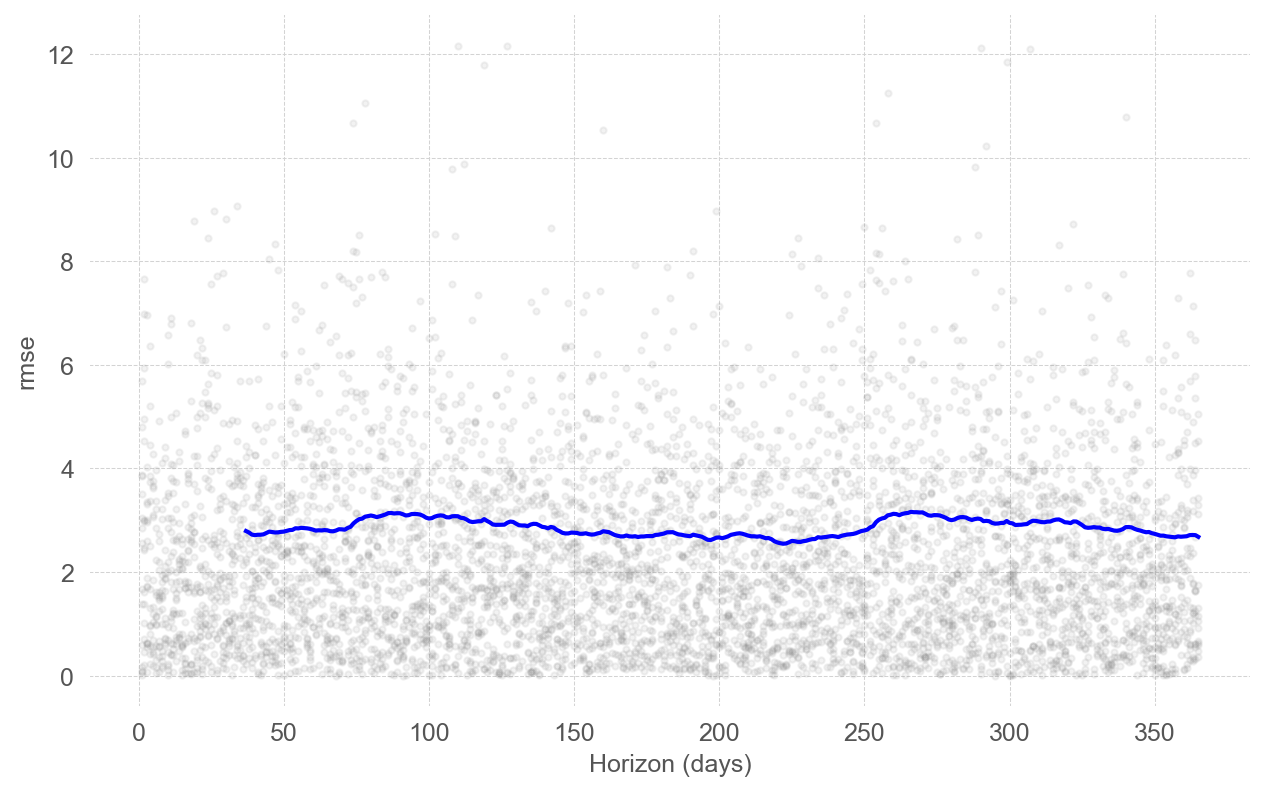

In [35]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

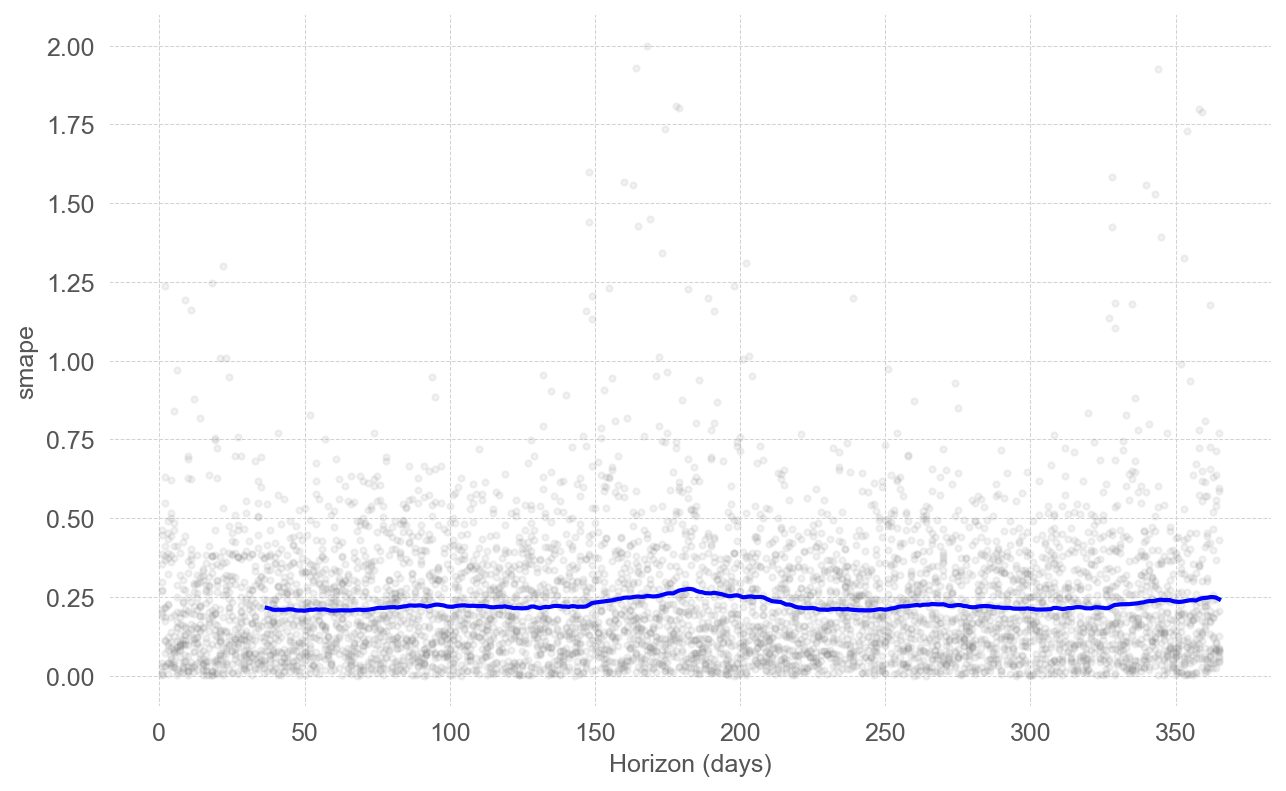

In [37]:
fig = plot_cross_validation_metric(df_cv, metric='smape')

## Hyperparameter Tuning
- `changepoint_prior_scale`: try values between 0.001 and 0.5
- `seasonality_prior_scale`: try values between 0.01 and 10
- `holidays_prior_scale`: try values between 0.01 and 10
- `seasonality_mode`: try `additive` or `multiplicative` 

In [ ]:
from itertools import product

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    # 'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    # 'seasonality_mode': ['additive','multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

rmses = []

for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial='730 days', horizon='365 days', period='180 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

In [39]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.00,0.01,2.92
1,0.00,0.10,2.87
2,0.00,1.00,2.88
3,0.00,10.00,2.88
4,0.01,0.01,2.82
5,0.01,0.10,2.83
6,0.01,1.00,2.82
7,0.01,10.00,2.83
8,0.10,0.01,3.50
9,0.10,0.10,2.90


In [40]:
best_params = all_params[np.argmin(rmses)]

print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


***